In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation


Use "Dict(a=>b for (a,b) in c)" instead.


## Gillespie

In [19]:
num_trials = 1000
in_parallel = true


c_r = 0.3
N = 400
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = 1.0

k =10
sigma_k = 10

TWO_DEGREE = 1
GAMMA = 2
REGULAR = 3

graph_type = REGULAR 
verbose = false

if verbose println(N, ' ' ,alpha, ' ',beta) end

###Set to true if we want by-node information on infecteds (much more data!)
carry_by_node_information = false
graph_model = true
in_parallel = true

# G = graph_from_two_degree_distribution(N,k,sigma_k)
# @time G = LightGraphs.random_regular_graph(N,k)
graph_data = nothing
if graph_type == GAMMA
    graph_fn = () -> graph_from_gamma_distribution(N,k,sigma_k)
    graph_data = sigma_k
elseif graph_type == TWO_DEGREE
    graph_fn = () -> graph_from_two_degree_distribution(N,k,sigma_k)
    graph_data = sigma_k
elseif graph_type == REGULAR
    graph_fn = () -> LightGraphs.random_regular_graph(N,k)
end

graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

# @time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph(N,im_normal,graph_information,fixation_threshold),in_parallel);
# yy,pp = get_p_reach(runs)
# yy /= N
@profile runs1 = run_epidemics_parallel(num_trials,() -> run_epidemic_graph_gillespie(N,im_normal,graph_information,fixation_threshold),in_parallel);
yy1,pp1 = get_p_reach(runs1)
yy1 /= N;


In [20]:
# println(runs[1].infecteds_vs_time)
# println(runs1[1].infecteds_vs_time)
Profile.print()

1    ./array.jl:0; splice!(::Array{Int64,1}, ::UnitR...
2    ./array.jl:56; unsafe_copy!(::Array{Int64,1}, ::...
2    ./dict.jl:0; ht_keyindex2(::Dict{Pair{Int64,In...
1    ./dict.jl:0; ht_keyindex(::Dict{Pair{Int64,Int...
3    ./float.jl:244; *(::Float64, ::Float64)
892  ./task.jl:360; (::IJulia.##13#19)()
 892 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  890 ...rc/execute_request.jl:157; execute_request(::ZMQ.Socket, ::...
   890 ./loading.jl:441; include_string(::String, ::String)
    889 ./<missing>:?; anonymous
     889 ./profile.jl:16; macro expansion;
      708 ./inference.jl:1616; typeinf_ext(::LambdaInfo)
       708 ./inference.jl:1592; typeinf_edge(::Method, ::Any,...
        708 ...lib/julia/sys.dylib:?; typeinf_loop(::Core.Inference....
         691 ./inference.jl:1672; typeinf_loop(::Core.Inferen...
          669 ./inference.jl:1726; typeinf_frame(::Core.Infere...
           669 ...ib/julia/sys.dylib:?; abstract_interpret(::Any, ::...
            669 ./inference.

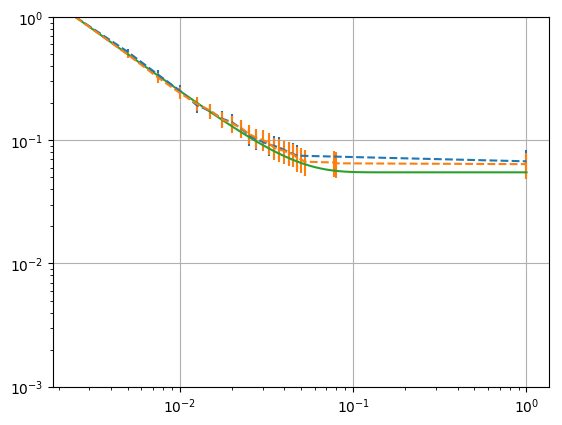

In [21]:
# loglog(yy/N,pp)
yyth = collect(1/N:1/N:1)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
ppth = P_reach_fast(im,N,1.0/N,yyth,true)
errorbars = 2*(pp.*(1-pp)/num_trials).^0.5
plt[:errorbar](yy,pp,linestyle="--",yerr=errorbars)#,label=simulation_labels[i])


errorbars = 2*(pp1.*(1-pp1)/num_trials).^0.5
plt[:errorbar](yy1,pp1,linestyle="--",yerr=errorbars)#,label=simulation_labels[i])

loglog(yyth,ppth)
loglog([],[])
ylim([1e-3,1])
grid()

In [2]:
num_trials = 1000
in_parallel = true


c_r = 0.3
N = 400
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = 1.0

k =10
sigma_k = 10

TWO_DEGREE = 1
GAMMA = 2

graph_type = TWO_DEGREE 
verbose = false

if verbose println(N, ' ' ,alpha, ' ',beta) end

###Set to true if we want by-node information on infecteds (much more data!)
carry_by_node_information = false
graph_model = true
in_parallel = true

# G = graph_from_two_degree_distribution(N,k,sigma_k)
graph_data = nothing
if graph_type == GAMMA
    graph_fn = () -> graph_from_gamma_distribution(N,k,sigma_k)
    graph_data = sigma_k
elseif graph_type == TWO_DEGREE
    graph_fn = () -> graph_from_two_degree_distribution(N,k,sigma_k)
    graph_data = sigma_k
end

graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

@time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph_experimental(N,im_normal,graph_information,fixation_threshold),in_parallel);
yy,pp = get_p_reach(runs)
yy /= N


LoadError: InterruptException:
 in ./(::Array{Int64,1}, ::Int64) at ./arraymath.jl:80
 in create_p_k_p_k_neighbor_from_graph(::LightGraphs.Graph) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/DegreeDistribution.jl:266
 in update_graph_experimental(::PayloadGraph.Graph{Int64}, ::IM.InfectionModel, ::Array{Int64,1}) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/SIS.jl:229
 in run_epidemic_graph_experimental(::Int64, ::IM.InfectionModel, ::Epidemics.GraphInformation, ::Float64) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/Epidemics.jl:159
 in (::Epidemics.##9#10{##9#10})(::Int64) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/Epidemics.jl:399
 in macro expansion at ./asyncmap.jl:63 [inlined]
 in (::Base.##755#757{Base.AsyncCollector,Base.AsyncCollectorState})() at ./task.jl:360

In [3]:
p_k_exp,p_k_neighbor_exp = create_p_k_p_k_neighbor_from_graph_fn(graph_fn,10)
num_trials_ = 10_000
hypergeometric = true
@time yy1,pp1,y_k_vec = get_p_reach_well_mixed_by_degree_simulation(N,alpha,beta,p_k_exp,p_k_neighbor_exp,num_trials_,hypergeometric)


  0.786327 seconds (2.60 M allocations: 274.013 MB, 6.14% gc time)


([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.13,0.1325,0.1375,0.1425,0.145,0.155,0.1625,0.1975,0.205,1.0],[1.0,0.4182,0.2869,0.2231,0.1857,0.1583,0.1382,0.1238,0.1131,0.1033  …  0.0441,0.044,0.0438,0.0436,0.0435,0.0434,0.0433,0.0432,0.0431,0.043],)

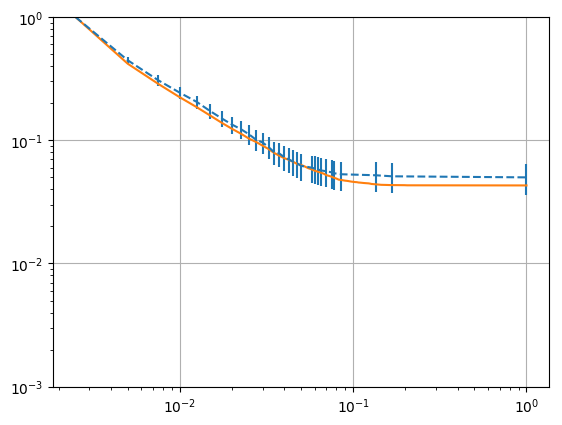

In [7]:
# loglog(yy/N,pp)
errorbars = 2*(pp.*(1-pp)/num_trials).^0.5
plt[:errorbar](yy,pp,linestyle="--",yerr=errorbars)#,label=simulation_labels[i])

loglog(yy1,pp1)
ylim([1e-3,1])
grid()